# GRU on Mario

Goal: train a simple GRU to generate Mario levels.

Basic idea: "The universal way to generate sequence data in deep learning is to train a network (usually an RNN or a convnet) to predict the next token or next few tokens in a sequence, using the previous tokens as input." (Deep Learning with Python by Francois Chollet)

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [8]:
import json

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/modules/')
from vglc_with_path_encodings import array_to_image
sys.path.append('/home/yangz2/projects/modules')
from log_training_progress import email_training_progress

In [3]:
torch.cuda.is_available()

True

## Load data

There's no need to one-hot encode the data because, as we will see later, our recurrent model has an `nn.Embedding` layer which does the similar thing as one-hot encoding.

In [4]:
with open('../data/lstm_data_46_progress.json') as json_f:
    inputs, labels = map(np.array, json.load(json_f))
inputs.shape, labels.shape

((43155, 46), (43155,))

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(inputs, labels, test_size=0.1, random_state=42)

In [6]:
if torch.cuda.is_available():
    train_ds = TensorDataset(torch.from_numpy(x_train).cuda(), torch.from_numpy(y_train).cuda())
    valid_ds = TensorDataset(torch.from_numpy(x_valid).cuda(), torch.from_numpy(y_valid).cuda())
else:
    train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    valid_ds = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
    
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=False)

## Define the model class

The model class looks very simple. Note that we don't need to maintain the hidden state of the GRU layer; this is done automatically by `nn.GRU`. However, to utilize the auto-passing of hidden state, `input` need to have shape `seq_len, bs, input_features` where `seq_len` equals to the number fo timesteps used for prediction. 

Also, the fact that this class is called RNN does not mean we are using the vanilla RNN.

In [7]:
class RNN(nn.Module):
    
    def __init__(self, num_tokens, hidden_size, n_layers, dropout):
        
        super(RNN, self).__init__()
        
        self.encoder = nn.Embedding(num_tokens, num_tokens)
        self.gru = nn.GRU(input_size=num_tokens, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, num_tokens)
    
    def forward(self, input):
        
        input = self.encoder(input)
        output, _ = self.gru(input)
        output = self.decoder(output)
        
        return output

## Understand how the model works

In [76]:
seq_len = 100
bs = 10
gru_input_size = 64  # dimension of encoding space
gru_hidden_size = 64
num_unique_chars = 20

In [77]:
embedding_layer = nn.Embedding(num_embeddings=num_unique_chars, embedding_dim=gru_input_size)
gru_layer = nn.GRU(gru_input_size, gru_hidden_size, num_layers=1)
decoder_layer = nn.Linear(gru_hidden_size, num_unique_chars)
loss_func = nn.CrossEntropyLoss()

In [78]:
input_batch = torch.zeros((seq_len, bs)).long()
print(input_batch.shape)
output_batch = torch.zeros((bs, )).long()

torch.Size([100, 10])


In [79]:
x = embedding_layer(input_batch)
print(f'{"After embedding":<20}:', x.shape)

x = gru_layer(x)
print(f'{"After GRU":<20}:', x[0].shape, x[1].shape)

x = decoder_layer(x[0])
print(f'{"After decoder":<20}:', x.shape)

print(f'{"Last prediction":<20}:', x[0].shape)
      
loss = loss_func(x[0], output_batch)
print(loss)

After embedding     : torch.Size([100, 10, 64])
After GRU           : torch.Size([100, 10, 64]) torch.Size([1, 10, 64])
After decoder       : torch.Size([100, 10, 20])
Last prediction     : torch.Size([10, 20])
tensor(2.6819, grad_fn=<NllLossBackward>)


In [17]:
gru_net = RNN(num_tokens=num_unique_chars, hidden_size=gru_hidden_size, n_layers=2, dropout=0.1)

In [79]:
gru_net(input_batch).shape

torch.Size([100, 10, 20])

## Training

In [29]:
hidden_size = 128
n_layers = 2
dropout = 0.5

n_epochs = 50 * 10
lr = 0.005

norm_val = 0.1

patience_val = 20

num_tokens = len(np.unique(inputs))

if torch.cuda.is_available():
    rnn = RNN(num_tokens, hidden_size, n_layers, dropout).cuda()
else:
    rnn = RNN(num_tokens, hidden_size, n_layers, dropout)

for p in rnn.parameters():
    if len(p.shape) > 1:  # skip biases
        nn.init.xavier_uniform_(p, gain=nn.init.calculate_gain('tanh'))

opt = torch.optim.Adam(rnn.parameters(), lr=lr)

loss_func = nn.CrossEntropyLoss()

tb = SummaryWriter()

In [30]:
def get_acc(logits : torch.tensor, labels : torch.tensor) -> float:
    logits = np.array(logits.detach().cpu())
    preds = np.argmax(logits, axis=-1)
    acc = np.mean(preds == labels.detach().cpu().numpy())
    return acc

In [31]:
max_val_acc = 0
patience = None

for epoch in tqdm_notebook(np.arange(1, n_epochs + 1)):
    
    # ========== model training ==========
    
    rnn.train()
    
    train_losses_per_epoch, train_accs_per_epoch = [], []
    
    for xb, yb in tqdm_notebook(train_dl, leave=False):
        
        # ========== feed-forward ==========

        history = xb.T.long()  # history's shape is (seq_len, bs); required by the GRU unit
        next_char_labels = yb.squeeze().long()
        
        next_char_logits = rnn(history)[-1]  # RNN(xb's) shape is (seq_len, bs, num_tokens)
        
        # ========== back-propagation ==========
        
        loss = loss_func(next_char_logits, next_char_labels)
        
        opt.zero_grad()
        loss.backward()
        
        # https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
        torch.nn.utils.clip_grad_norm_(rnn.parameters(), norm_val)
        
        opt.step()
        
        # ========== update / accumulate metrics ==========
        
        train_losses_per_epoch.append(float(loss))
        
        acc = get_acc(next_char_logits, next_char_labels)
        train_accs_per_epoch.append(acc)
    
    tb.add_scalar('train/loss', np.mean(train_losses_per_epoch), epoch)
    tb.add_scalar('train/acc', np.mean(train_accs_per_epoch), epoch)
    
    for i, p in enumerate(rnn.encoder.parameters()):
        tb.add_histogram(f'encoder.{i}.grad', p.grad, epoch)
        
    for i, p in enumerate(rnn.gru.parameters()):
        tb.add_histogram(f'gru.{i}.grad', p.grad, epoch)
    
    for i, p in enumerate(rnn.decoder.parameters()):
        tb.add_histogram(f'decoder.{i}.grad', p.grad, epoch)
    
    # ========== model validation ==========
    
    rnn.eval()
    
    valid_losses_per_epoch, valid_accs_per_epoch = [], []
    
    for xb, yb in tqdm_notebook(valid_dl, leave=False):
        
        history = xb.T.long()
        next_char_labels = yb.squeeze().long()
        
        next_char_logits = rnn(history)[-1]
        
        loss = loss_func(next_char_logits, next_char_labels)
        
        valid_losses_per_epoch.append(float(loss))
        valid_accs_per_epoch.append(get_acc(next_char_logits, next_char_labels))
    
    tb.add_scalar('valid/loss', np.mean(valid_losses_per_epoch), epoch)
    tb.add_scalar('valid/acc', np.mean(valid_accs_per_epoch), epoch)
    
    if patience is None:
        pass
    elif patience == 0:
        email_training_progress('early stopping reached')
        break
    else:
        patience -= 1
    
    if np.mean(valid_accs_per_epoch) > max_val_acc:
        max_val_acc = np.mean(valid_accs_per_epoch)
        torch.save(rnn.state_dict(), f'./model_checkpoints/{epoch}.pth')
        patience = patience_val

## Plot learning curve

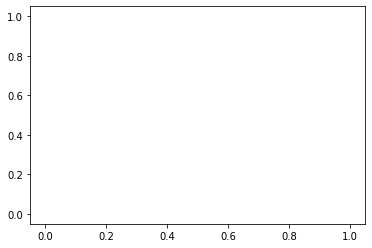

In [135]:
plt.plot(np.arange(1, len(losses)+1), losses)
plt.savefig(f'learning_curve_layers_{n_layers}_hs_{hidden_size}_epochs_{n_epochs}.png')

## Generation

In [32]:
rnn.load_state_dict(torch.load('model_checkpoints/30.pth'))


<All keys matched successfully>

In [33]:
rnn = rnn.cpu()

In [34]:
temperatures = [1]
num_levels_each_temp = 10
num_cols = 100
level_height = 15  # 14 + 1 (for telling the model where the bottom of the level is)
total_tiles = level_height * num_cols

/home/yangz2/anaconda3/envs/deep_learning/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


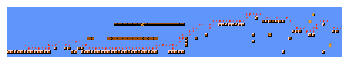

In [35]:
for temp in tqdm_notebook(temperatures):
    
    for level_idx in tqdm_notebook(range(num_levels_each_temp)):

        seed = torch.from_numpy(inputs[0]).long().view(-1, 1)
        level_gen = seed.clone().detach()

        num_gens = total_tiles - len(seed)

        for i in tqdm_notebook(np.arange(num_gens), leave=False):

            with torch.no_grad():
                logits = rnn(seed)[-1].view(-1)

            probas = F.softmax(logits / temp, dim=0)

            dist = Categorical(probas)
            next_index = dist.sample()

            level_gen = torch.cat([level_gen, next_index.view(-1, 1)])
            seed = torch.cat([seed[1:], next_index.view(-1, 1)])

        level_gen_2d = level_gen.numpy().reshape(level_height, num_cols, order='F')
        level_gen_2d[level_gen_2d == 12] = 2

        plt.imshow(array_to_image([level_gen_2d], game='smba')[0])
        plt.axis('off')
        plt.savefig(f'level_gen_{temp}_{level_idx}.png', dpi=150)

In [51]:

rnn(seed).shape




torch.Size([46, 1, 13])